In [2]:
from model import ToyNet, UNet
from diffusion import DiffusionProcess
import torch
from diffusion.utils.sde import SDE
import numpy as np
import logging

from pytorch_lightning import LightningDataModule
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import torch.nn as nn
from torch.distributions import Normal, Categorical, MixtureSameFamily
import torch
#device = 'mps'
device = 'cuda:0'
import random
from src.PCF_with_empirical_measure import PCF_with_empirical_measure

In [3]:
def init_seed(seed):
    torch.cuda.manual_seed_all(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
init_seed(1)

In [4]:
# Data distribution
mix = Categorical(torch.ones(2,))
comp = Normal(torch.tensor([0 - 2., 0 + 2.]), torch.tensor([.5, .5]))
data_dist = MixtureSameFamily(mix, comp)


In [25]:
class SDEProcess(DiffusionProcess):
    def __init__(self, sde_type="VP",
                 sde_info={"VP": {"beta_min": 0.1, "beta_max": 20},
                           "subVP": {"beta_min": 0.1, "beta_max": 20},
                           "VE": {"sigma_min": 0.01, "sigma_max": 50}}, 
                 **kwargs):
        super(SDEProcess, self).__init__(**kwargs)
        assert self.discrete is False, "DDPM is only for continuous data"
        self.dt = 1. / self.total_steps # step size
        self.sde = SDE(self.total_steps, sde_type, sde_info)
        
    def forward_one_step(self, x_prev, t):
        """
        Discretized forward SDE process for actual compuatation: 
        x_{t+1} = x_t + f_t(x_t) * dt + G_t * z_t * sqrt(dt)
        """
        f_t, g_t = self.sde.drifts(x_prev, t-1)
        z = torch.randn_like(x_prev)
        x_t = x_prev + f_t * self.dt + g_t * z * np.sqrt(self.dt)
        return x_t

    
    def backward_one_step(self, x_t, t, pred_score, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        #x_t = x_t.detach()
        z = torch.randn_like(x_t).to(device)
        f_t, g_t = self.sde.drifts(x_t, t)
        f_t = f_t.to(device)
        x_prev = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
        if clip_denoised and x_t.ndim > 2:
            print('backward_one_step')
            x_prev.clamp_(-1., 1.)

        return x_prev

    @torch.no_grad()
    def sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.hstack(trajs)
    
    def forward_sample(self, data):
        trajs = torch.zeros([len(data), self.total_steps+1])
        x = data.to(device)
        trajs[:, 0] = x
        for t in range(1, self.total_steps+1):
            x = self.forward_one_step(x, t)
            trajs[:, t] = x
        return x, trajs
    
    def backward_sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.hstack(trajs)


In [26]:

score_net = ToyNet(data_dim=1).to(device)
total_steps = 100
num_paths = 32
diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP")

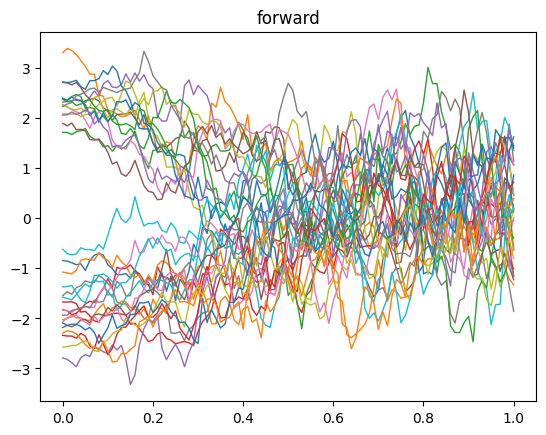

In [7]:
x_data_test = data_dist.sample([num_paths])
x_noise_test, traj_forward_test = diffusion.forward_sample(x_data_test)

xxx = np.linspace(0, 1, traj_forward_test.shape[1])
for line in traj_forward_test:
    plt.plot(xxx, line, linewidth=1.0)
    plt.title('forward')

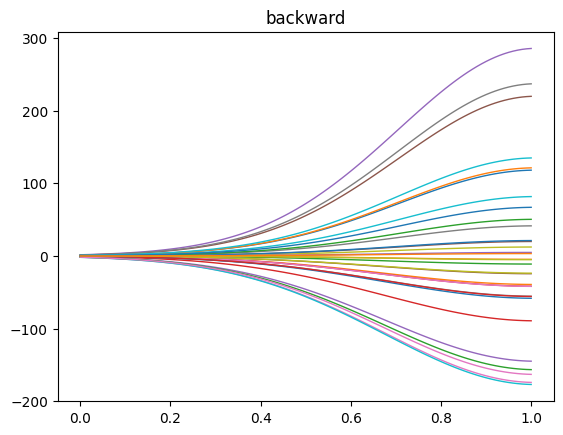

In [27]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).to(device), score_net)
xxx = np.linspace(0, 1, traj_forward_test.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')

In [13]:
score_net = ToyNet(data_dim=1).to(device)
total_steps = 100
num_paths = 32
diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP")

pcf = PCF_with_empirical_measure(16, 10, 1, add_time=True)
pcf = pcf.to(device)

G_opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)
D_opt = torch.optim.Adam(pcf.parameters(), lr=1e-3)

Train the network with PCF distance and reconstrucion loss. Time dimension has been added the PCF network.

I am using min-max way to train both PCF network and score network. 

Haven't test the combined loss with new backward sampling fucntion i.e. backward_sample_example that can been seen in latter block. will do later. 

In [9]:
num_epochs = 1000
for i in range(num_epochs):
    if 500 <i <=800:
        G_opt = torch.optim.Adam(score_net.parameters(), lr=5e-4)
        D_opt = torch.optim.Adam(pcf.parameters(), lr=5e-4)
    elif i>800:
        G_opt = torch.optim.Adam(score_net.parameters(), lr=1e-4)
        D_opt = torch.optim.Adam(pcf.parameters(), lr=1e-4)
    x_data = data_dist.sample([num_paths])
    x_noise, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device)
        
    
    # train the PCF network as a discriminator. We want PCF has a great ablitily to distinguish the real data and the generated data. 
    # So we train the PCF to maxmise the distance between the real data and the generated data.
    with torch.no_grad():
        x_gen, traj_back = diffusion.backward_sample(torch.cat((torch.randn([num_paths, 1]).to(device), traj_forward[:,-1].unsqueeze(1)),0), score_net)
        traj_forward_flip = torch.fliplr(traj_forward)
        traj_forward_flip_cat = torch.cat((traj_forward_flip.view([-1, total_steps+1, 1]),traj_forward_flip.view([-1, total_steps+1, 1])),0)

    pcf.train()
    D_loss = -pcf.distance_measure(traj_forward_flip_cat, traj_back.view([-1, total_steps+1, 1]), Lambda=1.0)

    D_opt.zero_grad()
    D_loss.backward()
    D_opt.step()
   
    # train the score network to minmise the distance between the real data and the generated data
    x_gen, traj_back = diffusion.backward_sample(torch.cat((torch.randn([num_paths, 1]).to(device), traj_forward[:,-1].unsqueeze(1)),0).to(device), score_net)
    x_gen1, traj_back1 = x_gen[num_paths:], traj_back[num_paths:]
    traj_back_flip1 = torch.fliplr(traj_back1)
    pcf.eval()
    
    G_loss =  pcf.distance_measure(traj_forward_flip_cat, traj_back.view([-1, total_steps+1, 1]), Lambda=1.0) + \
        0.5*torch.mean(((traj_forward - traj_back_flip1)**2).reshape(traj_forward.shape[0], -1), dim=(0,1))

    G_opt.zero_grad()
    G_loss.backward()
    G_opt.step()

    print(i, D_loss.item() , G_loss.item())

0 -2.2002665996551514 3962.474853515625
1 -2.263192653656006 78.91580963134766
2 -2.0683412551879883 16.353782653808594
3 -1.9131226539611816 6.549947738647461
4 -1.7429563999176025 5.433618545532227
5 -2.3431921005249023 4.456681251525879
6 -1.780582070350647 4.368833541870117
7 -2.2978897094726562 3.8115015029907227
8 -3.5173842906951904 5.353738307952881
9 -2.1769585609436035 4.076940536499023
10 -3.494542121887207 5.466286659240723
11 -3.1390085220336914 3.872340202331543
12 -3.4639666080474854 4.190269947052002
13 -3.570394992828369 5.04527473449707
14 -3.8969035148620605 4.752828121185303
15 -3.257126569747925 5.490683078765869
16 -4.357511043548584 5.3935041427612305
17 -3.5412206649780273 5.183843612670898
18 -4.1316399574279785 4.912771224975586
19 -3.9624736309051514 5.083960056304932
20 -5.014528274536133 6.651846885681152
21 -4.589746475219727 5.268115043640137
22 -4.746585369110107 4.7958526611328125
23 -3.892183303833008 6.5164313316345215
24 -3.9241535663604736 5.0210809

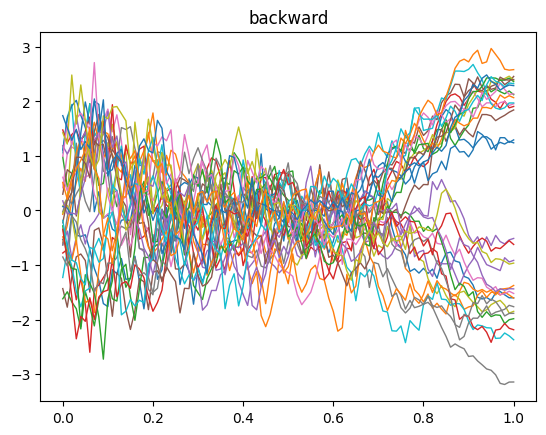

In [12]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).cuda(), score_net)
xxx = np.linspace(0, 1, traj_forward.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')

Train the model only using reconstruction loss. It gives a good result by using the improved backward sampling function (function name: backward_sample_example). 

In [116]:
from model import ToyNet, UNet
from diffusion import DiffusionProcess
import torch
from diffusion.utils.sde import SDE
import numpy as np
import logging

from pytorch_lightning import LightningDataModule
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import torch.nn as nn
from torch.distributions import Normal, Categorical, MixtureSameFamily
import torch
#device = 'mps'
device = 'cuda:0'
import random
from src.PCF_with_empirical_measure import PCF_with_empirical_measure

def init_seed(seed):
    torch.cuda.manual_seed_all(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
init_seed(1)

class SDEProcess(DiffusionProcess):
    def __init__(self, sde_type="VP",
                 sde_info={"VP": {"beta_min": 0.1, "beta_max": 20},
                           "subVP": {"beta_min": 0.1, "beta_max": 20},
                           "VE": {"sigma_min": 0.01, "sigma_max": 50}}, 
                 **kwargs):
        super(SDEProcess, self).__init__(**kwargs)
        assert self.discrete is False, "DDPM is only for continuous data"
        self.dt = 1. / self.total_steps # step size
        self.sde = SDE(self.total_steps, sde_type, sde_info)
        
    def forward_one_step(self, x_prev, t):
        """
        Discretized forward SDE process for actual compuatation: 
        x_{t+1} = x_t + f_t(x_t) * dt + G_t * z_t * sqrt(dt)
        """
        f_t, g_t = self.sde.drifts(x_prev, t-1)
        z = torch.randn_like(x_prev)
        x_t = x_prev + f_t * self.dt + g_t * z * np.sqrt(self.dt)
        return x_t

    
    def backward_one_step(self, x_t, t, pred_score, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        z = torch.randn_like(x_t).to(device)
        f_t, g_t = self.sde.drifts(x_t, t)
        f_t = f_t.to(device)
        x_prev = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
        if clip_denoised and x_t.ndim > 2:
            print('backward_one_step')
            x_prev.clamp_(-1., 1.)

        return x_prev

    @torch.no_grad()
    def sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.hstack(trajs)
    
    def forward_sample(self, data):
        trajs = torch.zeros([len(data), self.total_steps+1])
        x = data.to(device)
        trajs[:, 0] = x
        for t in range(1, self.total_steps+1):
            x = self.forward_one_step(x, t)
            trajs[:, t] = x
        return x, trajs
    
    def backward_sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score) #.detach()
            trajs.append(x_t)
        print(x_t.shape, torch.hstack(trajs).shape)
        return x_t, torch.hstack(trajs)
    
    def backward_sample_example(self, noise, net):
        """
        Sample from backward diffusion process
        noise: torch.tensor, shape=[num_paths, T]
        """
        # noise_start = noise[:, 0]
        noise_end = noise[:, -1]
        # trajs = [noise_end]
        trajs = torch.zeros_like(noise)
        trajs[:, -1] = noise_end
        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(noise[:,t].unsqueeze(1), t)
            x_t = self.backward_one_step(noise[:,t].unsqueeze(1), t, pred_score)
            trajs[:,t-1] = x_t.squeeze()
        return x_t, trajs #torch.hstack(trajs)

    
mix = Categorical(torch.ones(2,))
comp = Normal(torch.tensor([0 - 2., 0 + 2.]), torch.tensor([.5, .5]))
data_dist = MixtureSameFamily(mix, comp)


In [117]:
score_net = ToyNet(data_dim=1).to(device)
total_steps = 100
num_paths = 32
diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP")

pcf = PCF_with_empirical_measure(16, 10, 1, add_time=True)
pcf = pcf.to(device)

G_opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)
D_opt = torch.optim.Adam(pcf.parameters(), lr=1e-3)

In [130]:
num_epochs = 600
opt = torch.optim.Adam(score_net.parameters(), lr=1e-4)
for i in range(num_epochs):
    # Forward process to generate time series
    opt.zero_grad()
    x_data = data_dist.sample([num_paths])
    x_noise, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device) # B, T
    # Backward process to generate time series
    x_gen1, traj_back1 = diffusion.backward_sample_example(traj_forward.to(device), score_net) 
    # traj_back_flip1 = torch.fliplr(traj_back1)
    # print(traj_back_flip1[0,-1].item(), traj_forward[0,-1].item(),traj_back_flip1[0,0].item())
    loss = (torch.mean(((traj_forward - traj_back1)**2).reshape(traj_forward.shape[0], -1), dim=(0,1)))
    loss.backward()
    opt.step()
    print(i, loss)

0 tensor(0.1998, device='cuda:0', grad_fn=<MeanBackward1>)
1 tensor(0.2038, device='cuda:0', grad_fn=<MeanBackward1>)
2 tensor(0.1969, device='cuda:0', grad_fn=<MeanBackward1>)
3 tensor(0.1941, device='cuda:0', grad_fn=<MeanBackward1>)
4 tensor(0.1892, device='cuda:0', grad_fn=<MeanBackward1>)
5 tensor(0.2059, device='cuda:0', grad_fn=<MeanBackward1>)
6 tensor(0.2007, device='cuda:0', grad_fn=<MeanBackward1>)
7 tensor(0.1937, device='cuda:0', grad_fn=<MeanBackward1>)
8 tensor(0.2000, device='cuda:0', grad_fn=<MeanBackward1>)
9 tensor(0.1890, device='cuda:0', grad_fn=<MeanBackward1>)
10 tensor(0.2107, device='cuda:0', grad_fn=<MeanBackward1>)
11 tensor(0.1947, device='cuda:0', grad_fn=<MeanBackward1>)
12 tensor(0.2023, device='cuda:0', grad_fn=<MeanBackward1>)
13 tensor(0.1975, device='cuda:0', grad_fn=<MeanBackward1>)
14 tensor(0.2087, device='cuda:0', grad_fn=<MeanBackward1>)
15 tensor(0.2032, device='cuda:0', grad_fn=<MeanBackward1>)
16 tensor(0.2072, device='cuda:0', grad_fn=<MeanBa

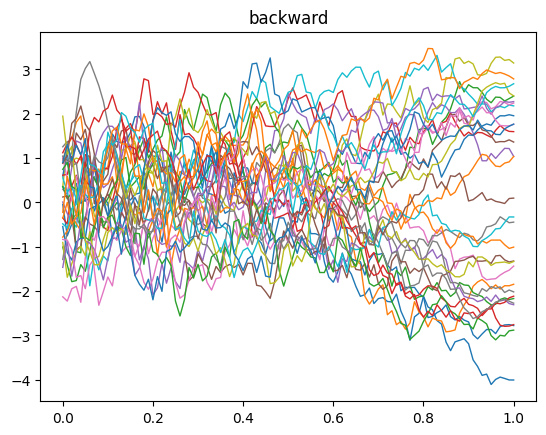

In [148]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).cuda(), score_net)
xxx = np.linspace(0, 1, traj_forward.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')

Train the model only using PCF loss with improved backward function (functin name: backward_sample_example). 



In [151]:
from model import ToyNet, UNet
from diffusion import DiffusionProcess
import torch
from diffusion.utils.sde import SDE
import numpy as np
import logging

from pytorch_lightning import LightningDataModule
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import torch.nn as nn
from torch.distributions import Normal, Categorical, MixtureSameFamily
import torch
#device = 'mps'
device = 'cuda:0'
import random
from src.PCF_with_empirical_measure import PCF_with_empirical_measure

def init_seed(seed):
    torch.cuda.manual_seed_all(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
init_seed(1)

class SDEProcess(DiffusionProcess):
    def __init__(self, sde_type="VP",
                 sde_info={"VP": {"beta_min": 0.1, "beta_max": 20},
                           "subVP": {"beta_min": 0.1, "beta_max": 20},
                           "VE": {"sigma_min": 0.01, "sigma_max": 50}}, 
                 **kwargs):
        super(SDEProcess, self).__init__(**kwargs)
        assert self.discrete is False, "DDPM is only for continuous data"
        self.dt = 1. / self.total_steps # step size
        self.sde = SDE(self.total_steps, sde_type, sde_info)
        
    def forward_one_step(self, x_prev, t):
        """
        Discretized forward SDE process for actual compuatation: 
        x_{t+1} = x_t + f_t(x_t) * dt + G_t * z_t * sqrt(dt)
        """
        f_t, g_t = self.sde.drifts(x_prev, t-1)
        z = torch.randn_like(x_prev)
        x_t = x_prev + f_t * self.dt + g_t * z * np.sqrt(self.dt)
        return x_t

    
    def backward_one_step(self, x_t, t, pred_score, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        z = torch.randn_like(x_t).to(device)
        f_t, g_t = self.sde.drifts(x_t, t)
        f_t = f_t.to(device)
        x_prev = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
        if clip_denoised and x_t.ndim > 2:
            print('backward_one_step')
            x_prev.clamp_(-1., 1.)

        return x_prev

    @torch.no_grad()
    def sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.hstack(trajs)
    
    def forward_sample(self, data):
        trajs = torch.zeros([len(data), self.total_steps+1])
        x = data.to(device)
        trajs[:, 0] = x
        for t in range(1, self.total_steps+1):
            x = self.forward_one_step(x, t)
            trajs[:, t] = x
        return x, trajs
    
    def backward_sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score) #.detach()
            trajs.append(x_t)
        print(x_t.shape, torch.hstack(trajs).shape)
        return x_t, torch.hstack(trajs)
    
    def backward_sample_example(self, noise, net):
        """
        Sample from backward diffusion process
        noise: torch.tensor, shape=[num_paths, T]
        """
        # noise_start = noise[:, 0]
        noise_end = noise[:, -1]
        # trajs = [noise_end]
        trajs = torch.zeros_like(noise)
        trajs[:, -1] = noise_end
        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(noise[:,t].unsqueeze(1), t)
            x_t = self.backward_one_step(noise[:,t].unsqueeze(1), t, pred_score)
            trajs[:,t-1] = x_t.squeeze()
        return x_t, trajs #torch.hstack(trajs)

    
mix = Categorical(torch.ones(2,))
comp = Normal(torch.tensor([0 - 2., 0 + 2.]), torch.tensor([.5, .5]))
data_dist = MixtureSameFamily(mix, comp)


In [150]:
score_net = ToyNet(data_dim=1).to(device)
total_steps = 100
num_paths = 32
diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP")

pcf = PCF_with_empirical_measure(16, 10, 1, add_time=True)
pcf = pcf.to(device)

G_opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)
D_opt = torch.optim.Adam(pcf.parameters(), lr=1e-3)

In [154]:
num_epochs = 2000
for i in range(num_epochs):
    if 1000<i <=1500:
        G_opt = torch.optim.Adam(score_net.parameters(), lr=5e-4)
        D_opt = torch.optim.Adam(pcf.parameters(), lr=5e-4)
    elif i>1500:
        G_opt = torch.optim.Adam(score_net.parameters(), lr=1e-4)
        D_opt = torch.optim.Adam(pcf.parameters(), lr=1e-4)
    x_data = data_dist.sample([num_paths])
    x_noise, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device)

    # train the PCF network as a discriminator. We want PCF has a great ablitily to distinguish the real data and the generated data. 
    # So we train the PCF to maxmise the distance between the real data and the generated data.
    for j in range(2):
        with torch.no_grad():
            x_gen, traj_back = diffusion.backward_sample_example(traj_forward.to(device), score_net)
            # traj_forward_flip = torch.fliplr(traj_forward)
        pcf.train()
        D_loss = -pcf.distance_measure(traj_forward.view([-1, total_steps+1, 1]), traj_back.view([-1, total_steps+1, 1]),Lambda=0.0)

        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()
   
    # train the score network to minmise the distance between the real data and the generated data
    x_gen, traj_back = diffusion.backward_sample_example(traj_forward, score_net)
    pcf.eval()
    G_loss =  (pcf.distance_measure(traj_forward.view([-1, total_steps+1, 1]), traj_back.view([-1, total_steps+1, 1]), Lambda=0.0))
           
    G_opt.zero_grad()
    G_loss.backward()
    G_opt.step()

    print(i, D_loss.item() , G_loss.item())

0 -0.014440732076764107 0.016562569886446
1 -0.015906792134046555 0.01730169542133808
2 -0.016233768314123154 0.013213464990258217
3 -0.013777796179056168 0.01233694702386856
4 -0.011038197204470634 0.009957865811884403
5 -0.013074822723865509 0.0128307631239295
6 -0.011545738205313683 0.010674054734408855
7 -0.014219043776392937 0.014965368434786797
8 -0.014202785678207874 0.011524843983352184
9 -0.01537022739648819 0.013144006952643394
10 -0.01428135670721531 0.0144197391346097
11 -0.012201642617583275 0.01741725206375122
12 -0.012642975896596909 0.01319931447505951
13 -0.013483252376317978 0.014122875407338142
14 -0.014789627864956856 0.012439742684364319
15 -0.011807671748101711 0.013990620151162148
16 -0.012663902714848518 0.011694075539708138
17 -0.015490740537643433 0.014021096751093864
18 -0.01458972878754139 0.01388053223490715
19 -0.012850934639573097 0.016543187201023102
20 -0.017592422664165497 0.015695659443736076
21 -0.016661029309034348 0.01237573940306902
22 -0.01581493

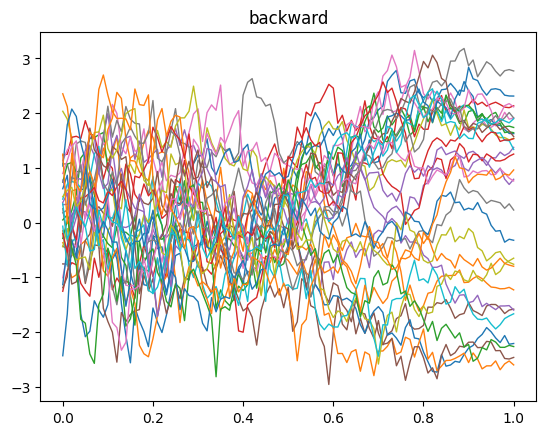

In [156]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).cuda(), score_net)
xxx = np.linspace(0, 1, traj_forward.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')

Standard diffusion training (Score matching loss from MX). 

In [65]:
score_net = ToyNet(data_dim=1).to(device)
total_steps = 100
num_paths = 32
diffusion_process = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP")

In [66]:
import torch.nn.functional as F
def loss_function(x0, diffusion_process, score_net, t):
    #f_t is not involved in the score matching loss soe input zeros for the 1st argument.
    #
    _, g_t = diffusion_process.sde.drifts(torch.zeros_like(x0), t)
    
    # Eq 29 in Score based diffusion model (Yang Song 2021 ICLR)
    mean, std = diffusion_process.sde.perturbation_kernel(x0, t)
    z = torch.randn_like(x0)

    x_t = mean + std * z  # x_t is perturbed x_0
    pred_score = score_net(x_t, t)
    target = -z / std   # Since desired derivative of the given kernel is - (x_t - mean) / std^2
    loss = g_t**2 * torch.mean((pred_score-target)**2, axis=(0,1)) / np.prod(x0.size())
    return loss

In [69]:
num_epochs = 1500
opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)

for i in range(num_epochs):
    # Forward process to generate time series
    opt.zero_grad()
    x0 = data_dist.sample([num_paths]).to(device)
    t = np.random.randint(1, total_steps + 1)
    loss = loss_function(x0.view(-1 ,1), diffusion_process, score_net, t)
    loss.backward()
    opt.step()
    print(i, loss)

0 tensor(0.1835, device='cuda:0', grad_fn=<DivBackward0>)
1 tensor(0.3042, device='cuda:0', grad_fn=<DivBackward0>)
2 tensor(3.2616, device='cuda:0', grad_fn=<DivBackward0>)
3 tensor(0.1537, device='cuda:0', grad_fn=<DivBackward0>)
4 tensor(0.1435, device='cuda:0', grad_fn=<DivBackward0>)
5 tensor(0.1293, device='cuda:0', grad_fn=<DivBackward0>)
6 tensor(0.1548, device='cuda:0', grad_fn=<DivBackward0>)
7 tensor(0.0529, device='cuda:0', grad_fn=<DivBackward0>)
8 tensor(0.2267, device='cuda:0', grad_fn=<DivBackward0>)
9 tensor(0.1912, device='cuda:0', grad_fn=<DivBackward0>)
10 tensor(0.6561, device='cuda:0', grad_fn=<DivBackward0>)
11 tensor(0.1231, device='cuda:0', grad_fn=<DivBackward0>)
12 tensor(0.0607, device='cuda:0', grad_fn=<DivBackward0>)
13 tensor(0.0368, device='cuda:0', grad_fn=<DivBackward0>)
14 tensor(0.0800, device='cuda:0', grad_fn=<DivBackward0>)
15 tensor(0.0318, device='cuda:0', grad_fn=<DivBackward0>)
16 tensor(0.0294, device='cuda:0', grad_fn=<DivBackward0>)
17 tens

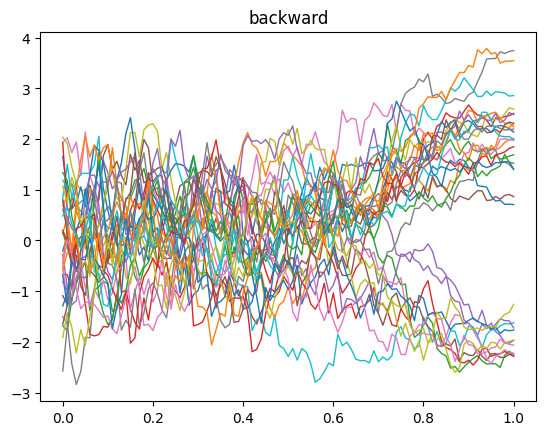

In [70]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).cuda(), score_net)
xxx = np.linspace(0, 1, traj_forward.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')